In [4]:
## Kalau kerjakan di google colab, install dulu emcee dan corner
# !pip install -U emcee
# !pip install corner

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import emcee
import corner
from scipy import stats

Dokumentasi emcee: https://emcee.readthedocs.io/en/stable/

Dokumentasi corner: https://corner.readthedocs.io/en/latest/

# MCMC

MCMC berguna untuk mengambil sampel pada suatu fungsi (populasi) yang terdistribusi $\sim f(\theta)$.

Contoh: Mengambil sampel distribusi normal

langkah:

1. definisikan fungsi (distribusi) tujuan: Biasa disebut (fungsi distribusi) posterior

  * Seringkali, distribusi posterior merupakan perkalian distribusi prior dan fungsi likelihood, sehingga definisikan terlebih dahulu distribusi prior dan fungsi likelihood

2. Tentukan posisi awal pejalan (*walker*).

  * Penting untuk memilih posisi awal pejalan yang tidak menghasilkan nilai posterior nol.

3. Buat mesin (objek) MCMC.
  * Pada latihan ini kita gunakan **emcee**

4. Simpan hasil.
  


### Fungsi Distribusi

contoh: distribusi normal, distribusi Poisson, distribusi datar (*uniform*), dll

Untuk kasus yang kita kerjakan, fungsi distribusi boleh merupakan fungsi distribusi _tak ternormalisasi_

Distribusi normal:
\begin{align}
  f(x;\mu, \sigma) &= \frac{1}{\sqrt{2\pi\sigma^2}}\exp{\left[-\frac{\left(x-\mu\right)^2}{2\sigma^2}\right]} \\
  &\propto \exp{\left[-\frac{\left(x-\mu\right)^2}{2\sigma^2}\right]}
\end{align}

In [2]:
def normal(x, mu, sigma):
  return np.exp(-np.power(x-mu, 2)/(2*np.power(sigma, 2)))

In [3]:
# from scipy
stats.norm.pdf(1, loc=2, scale=3)

0.12579440923099774

Distribusi datar:
\begin{align}
  f(x; a, b) \propto \begin{cases}
    1 & \text{jika } a < x < b, \\
    0 & \text{lainnya.}
  \end{cases}
\end{align}

In [4]:
def uniform(x, a, b):
  return np.select([x < a, x > b], [0, 0], default=1)

uniform(2, 1, 3)

array(1)

In [5]:
# from scipy
stats.uniform.pdf(2,1,3)

0.3333333333333333

## Contoh 1: Distribusi normal 1 dimensi

In [2]:
# Definisikan (log) fungsi distribusi probabilitas
def log_prob(x, mu, sigma):
  return stats.norm.logpdf(x, loc=mu, scale=sigma)

mu = 15
sigma = 2

In [3]:
# posisi awal pejalan
ndim = 1
nwalkers = 10 # minimal 2 kali ndim

p0 = np.random.rand(nwalkers, ndim) # posisi awal dalam bentuk matrik nwalkers x ndim
p0

array([[0.41076499],
       [0.85540309],
       [0.17154151],
       [0.59453774],
       [0.26594859],
       [0.05046008],
       [0.64688297],
       [0.08425384],
       [0.12943548],
       [0.99979422]])

In [4]:
# cek apakah ada posisi awal yang memiliki nilai log_prob = -inf
# jika ya, ulangi penentuan posisi awal
log_prob(p0, mu, sigma)

array([[-28.21780797],
       [-26.62078843],
       [-29.09748335],
       [-27.55175359],
       [-28.74861959],
       [-29.54817867],
       [-27.36358178],
       [-29.42202116],
       [-29.25379684],
       [-26.11280597]])

In [6]:
# buat objek emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[mu, sigma])

In [7]:
nsteps = 100 # jumlah langkah mula-mula
state = sampler.run_mcmc(p0, nsteps, progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 450.28it/s]


isi _state_ (https://emcee.readthedocs.io/en/stable/user/sampler/)

In [8]:
state.coords # posisi terakhir pejalan

array([[14.6681591 ],
       [15.99586667],
       [14.59013514],
       [19.03292624],
       [13.13591511],
       [14.81382682],
       [12.8270421 ],
       [12.80090682],
       [15.73866429],
       [15.90413538]])

In [9]:
state.log_prob # log prob pejalan di coords

array([-1.62585051, -1.73605452, -1.63308436, -3.64514747, -2.04643727,
       -1.61641827, -2.20230397, -2.21658706, -1.68028883, -1.71426831])

cek *chain plot/trace plot*

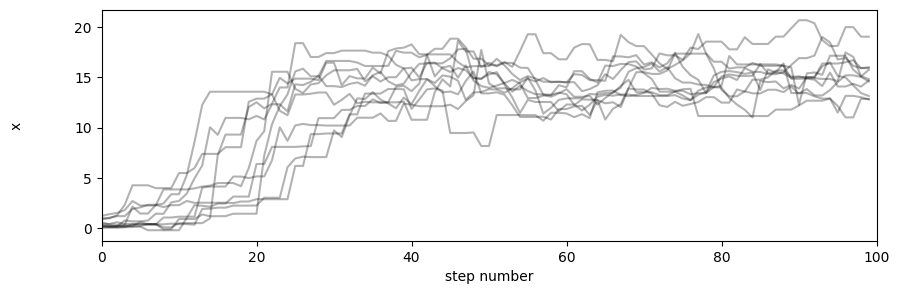

In [10]:
fig, axes = plt.subplots(ndim, figsize=(10, 3), sharex=True)
axes = np.atleast_1d(axes)
samples = sampler.get_chain()
labels = ["x"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

In [11]:
sampler.reset()

In [12]:
sampler.run_mcmc(state.coords, 5000, progress=True);
# sampler.run_mcmc(state, 5000, progress=True); # ini juga bisa, masukan posisi terakhir pejalan atau variabel *state*

100%|██████████| 5000/5000 [00:06<00:00, 757.80it/s]


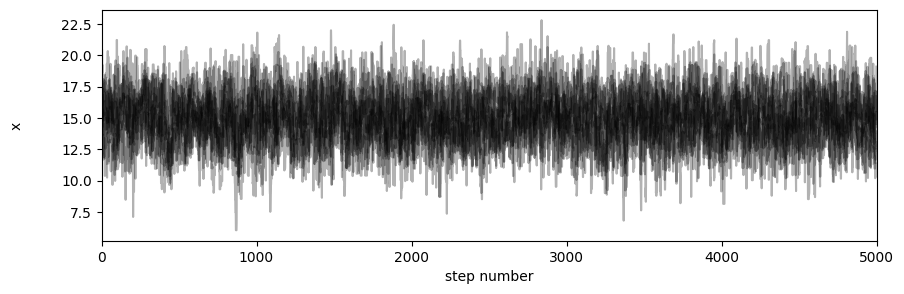

In [13]:
fig, axes = plt.subplots(ndim, figsize=(10, 3), sharex=True)
axes = np.atleast_1d(axes)
samples = sampler.get_chain()
labels = ["x"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

In [14]:
# opsional, cek nilai autokorelasi
tau = sampler.get_autocorr_time()
tau

array([28.55712525])

nilai autokorelasi bisa digunakan untuk menentukan jumlah langkah awal yang perlu dijalankan harusnya berapa.

Pada kasus ini, nilainya $\tau=30$, sedangkan awalnya kita jalankan sebesar $n_0=100$ langkah. Karena $n_0>\tau$, maka *oke*. Lebih baik lagi jika $n_0>5\times \tau$

In [15]:
# ratakan/flatten nilai-nilai pejalan.

flat_samples = sampler.get_chain(discard=0, thin=15, flat=True)
flat_samples.shape

(3330, 1)

plot histogram

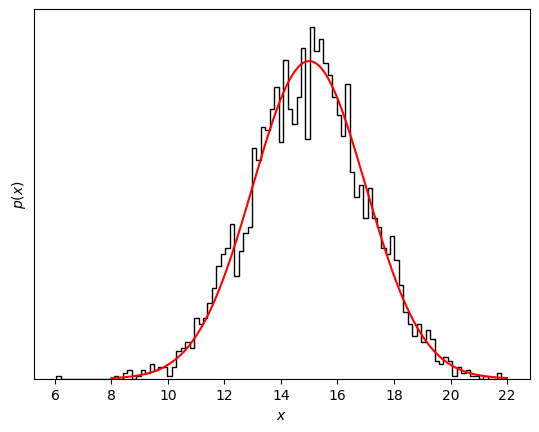

In [16]:
x = np.linspace(8, 22, 500)
px = stats.norm.pdf(x, mu, sigma)

plt.hist(flat_samples[:, 0], 100, color="k", histtype="step", density=True)
plt.plot(x, px, c="r")
plt.plot()
plt.xlabel(r"$x$")
plt.ylabel(r"$p(x)$")
plt.gca().set_yticks([]);

# Contoh 2: Distribusi Normal 5D

In [17]:
# cek https://en.wikipedia.org/wiki/Multivariate_normal_distribution untuk definisi rumusnya

def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

ndim = 5
np.random.seed(42)
means = np.array([15, 15, 20, 30, -10]) # nilai mu masing-masing

cov = 0.5 - np.random.rand(ndim**2).reshape((ndim, ndim)) # pilih acak nilai kovariannya
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)

In [18]:
# posisi awal pejalan
nwalkers = 5 * ndim
p0 = np.random.rand(nwalkers, ndim)
p0.shape

(25, 5)

In [19]:
for p0_i in p0:
  print(log_prob(p0_i, means, cov))

-124883.07025666401
-110135.95127326857
-115407.34494304669
-119956.72357372646
-122451.40682610679
-107363.36620565891
-122403.22283241487
-125971.11864334572
-117156.02486695512
-112445.43845448182
-115546.90505061059
-115867.1688287683
-114045.81789214414
-113517.76849608411
-123997.2829639861
-112013.10782138084
-128570.56063067466
-121466.21501834466
-106021.91598500406
-113459.55703511267
-116006.51749863906
-114127.59264594276
-112300.96986018922
-120258.01201277607
-124284.40572671928


In [20]:
import time

nsteps = 2000

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])
start = time.time()
sampler.run_mcmc(p0, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))

100%|██████████| 2000/2000 [00:01<00:00, 1328.34it/s]

Serial took 1.5 seconds


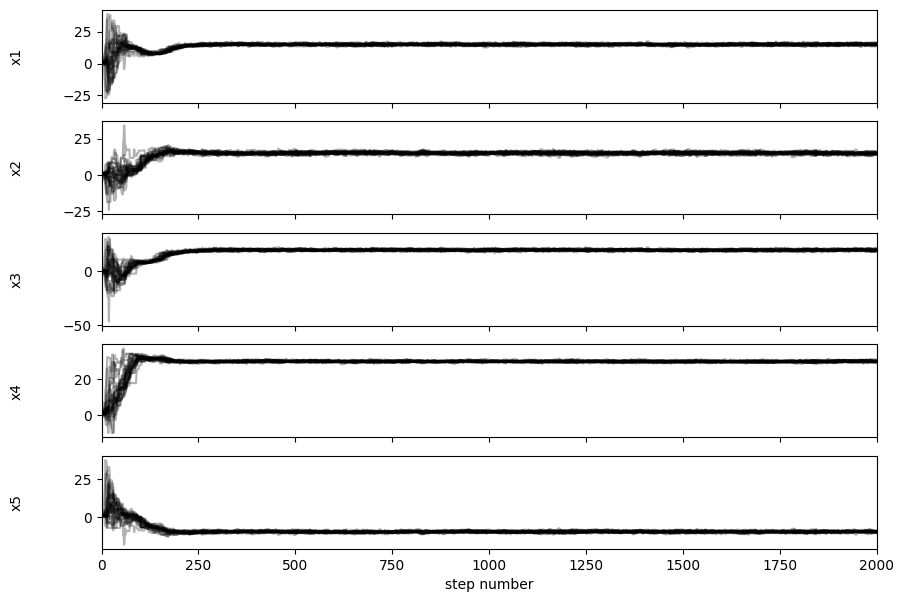

In [21]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
axes = np.atleast_1d(axes)
samples = sampler.get_chain()
labels = ["x1", "x2", "x3", "x4", "x5"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

### Paralelisasi

In [22]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

8 CPUs


Dari https://emcee.readthedocs.io/en/stable/tutorials/parallel/

> Some builds of NumPy (including the version included with Anaconda) will automatically parallelize some operations using something like the MKL linear algebra. This can cause problems when used with the parallelization methods described here so it can be good to turn that off (by setting the environment variable OMP_NUM_THREADS=1, for example).


In [25]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [27]:
from multiprocessing import Pool
state = None

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov], pool=pool)
    start = time.time()
    state = sampler.run_mcmc(p0, nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("\nMultiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

100%|██████████| 2000/2000 [00:18<00:00, 108.40it/s]


Multiprocessing took 18.5 seconds
0.1 times faster than serial


Tidak semua *paralelisasi* artinya lebih cepat, jadi hati-hati.

In [29]:
nsteps = 20_000

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])
sampler.run_mcmc(p0, nsteps, progress=True);

100%|██████████| 20000/20000 [00:23<00:00, 847.54it/s] 


In [30]:
tau = sampler.get_autocorr_time()
print(tau)

[ 85.04308263  83.64906329 137.24310703  50.7909154   94.24683631]


85.04308263131415
83.64906329368812
137.24310703243248
50.790915404742066
94.24683631320255


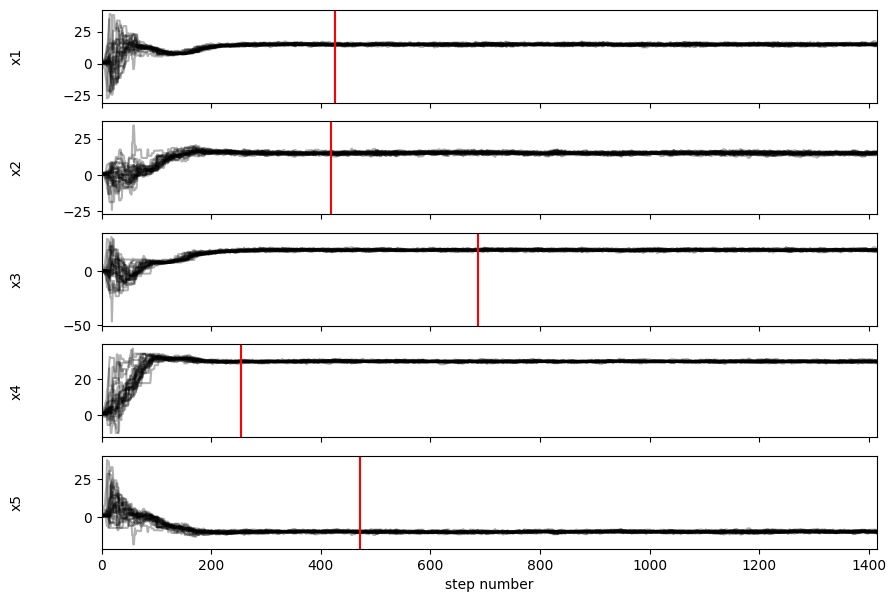

In [31]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
axes = np.atleast_1d(axes)
samples = sampler.get_chain()
labels = ["x1", "x2", "x3", "x4", "x5"]
for i, t in enumerate(tau):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    # ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axvline(5*t, c="r")
    ax.set_xlim(0, 15*t)
    print(t)
axes[-1].set_xlabel("step number");

In [32]:
thin = np.max((tau//2).astype(int))
thin

68

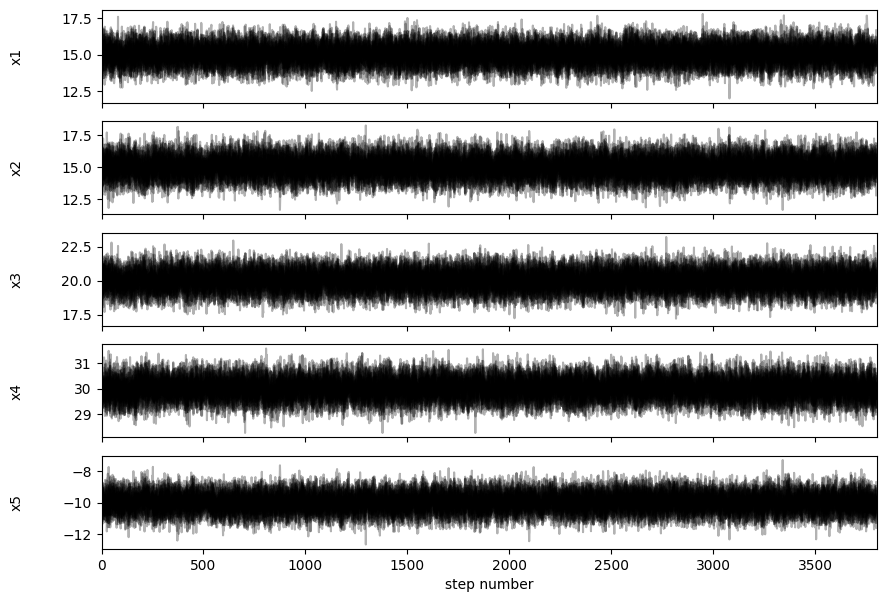

In [33]:
burn = 1000
thin = 5

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
axes = np.atleast_1d(axes)
samples = sampler.get_chain(discard=burn, thin=thin)
labels = ["x1", "x2", "x3", "x4", "x5"]
for i, t in enumerate(tau):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

In [34]:
flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
flat_samples.shape

(95000, 5)

### corner plot

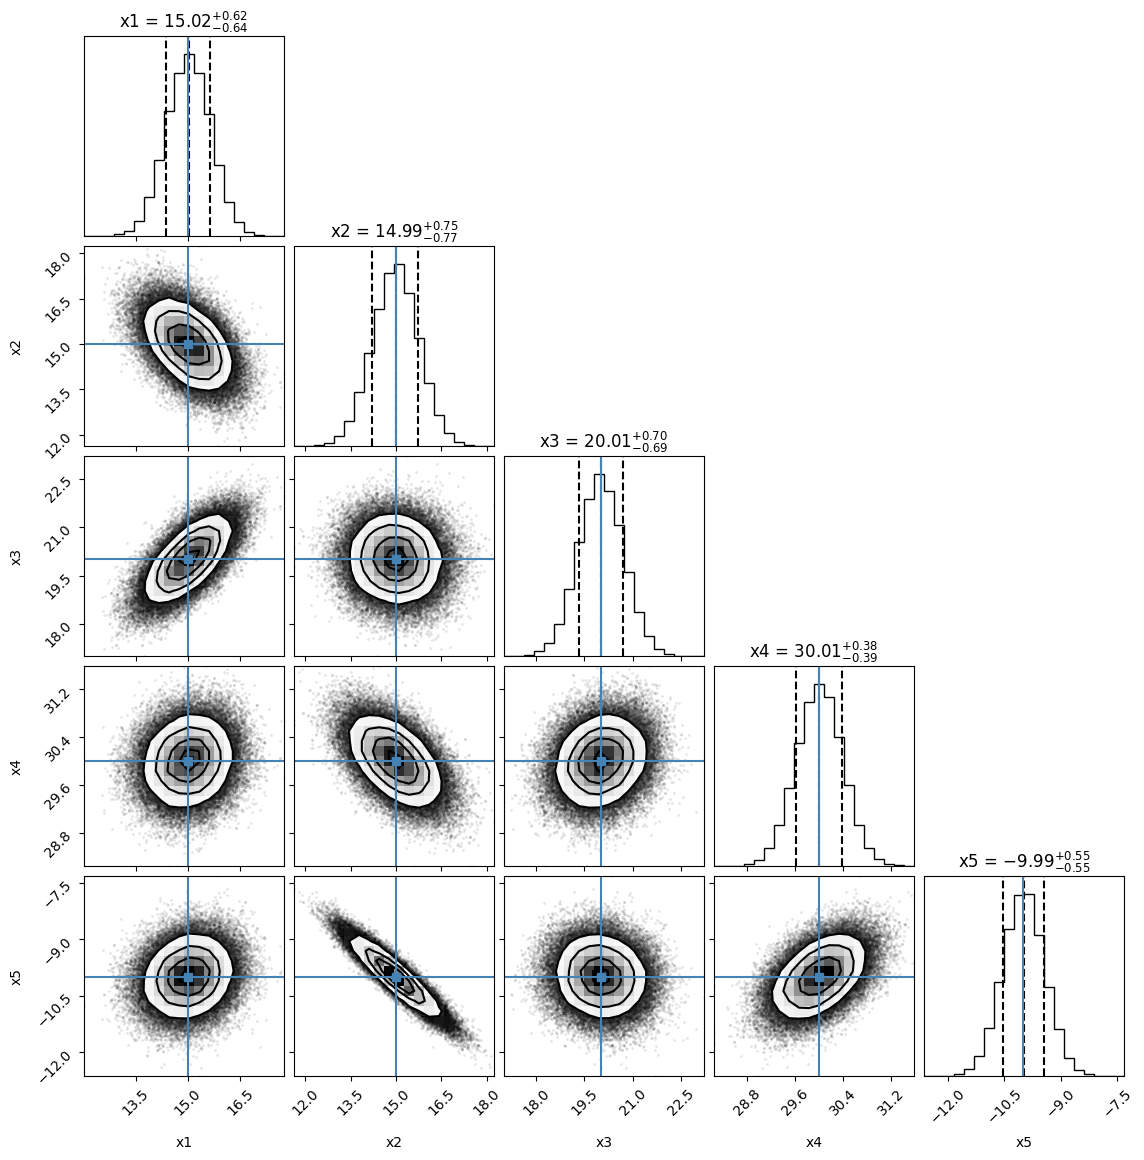

In [35]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=means,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
);

# Contoh 3: Fit Garis

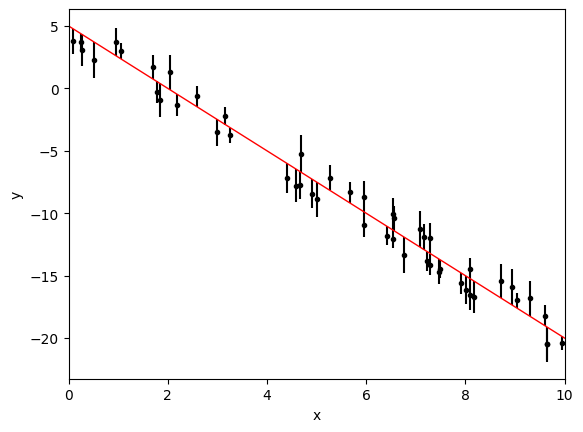

In [41]:
np.random.seed(12345)

# Choose the "true" parameters.
m_true = -2.5
b_true = 5

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = np.abs(0.5 + 1 * np.random.rand(N))
y = m_true * x + b_true + yerr*np.random.choice([-1, 1], size=N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "r", lw=1)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [42]:
data = np.array([x, y, yerr])
data.shape

(3, 50)

In [43]:
def log_prior(theta):
  m = theta[0]
  b = theta[1]
  alpha = np.arctan(m)
  log_prior_alpha = stats.uniform.logpdf(alpha, loc=-np.pi/2, scale=np.pi)
  log_prior_b = stats.uniform.logpdf(b, loc=0, scale=10)
  return log_prior_alpha + log_prior_b

def model(x, m, b):
  return b + m*x

def log_likelihood(theta, data):
  m = theta[0]
  b = theta[1]

  x = data[0]
  y = data[1]
  yerr = data[2]

  ymod = model(x, m, b)

  log_res = stats.norm.logpdf(ymod, loc=y, scale=yerr)
  return np.sum(log_res)

def log_prob(theta, data):
  log_prior_val = log_prior(theta)
  if np.isinf(log_prior_val):
    return -np.inf
  return log_prior_val + log_likelihood(theta, data)

In [44]:
theta = np.array([m_true, b_true])

print("prior", log_prior(theta))
print("likelihood", log_likelihood(theta, data))
print("posterior", log_prob(theta, data))

prior -3.447314978843446
likelihood -72.06394743249284
posterior -75.51126241133629


In [45]:
ndim = 2
nwalkers = 16

m0 = stats.uniform.rvs(size=nwalkers, loc=-1, scale=4)
b0 = stats.uniform.rvs(size=nwalkers, loc=0.1, scale=9.8)

p0 = np.array([m0, b0]).T
p0

array([[ 2.76618518,  6.087264  ],
       [ 0.66145342,  3.67200481],
       [ 0.0577599 ,  1.62917817],
       [-0.61042734,  1.83757737],
       [ 0.94337689,  8.60531878],
       [ 0.85865145,  2.94292775],
       [-0.88096273,  5.83476029],
       [ 1.77710985,  4.54914978],
       [ 1.86778845,  4.1295457 ],
       [ 1.91924569,  8.74981756],
       [ 0.65740407,  6.88853854],
       [-0.93960462,  2.83687888],
       [ 2.63590063,  0.73151427],
       [ 2.15751487,  2.04651141],
       [-0.33920332,  9.2304909 ],
       [ 0.25114385,  8.47325296]])

In [50]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(data,)
)

nsteps = 200
state = sampler.run_mcmc(p0, nsteps, progress=True);

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:01<00:00, 143.10it/s]


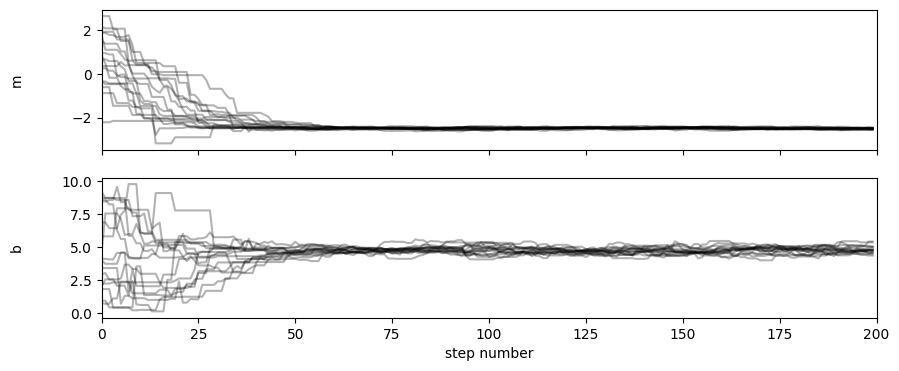

In [48]:
fig, axes = plt.subplots(ndim, figsize=(10, 4), sharex=True)
axes = np.atleast_1d(axes)
samples = sampler.get_chain()
labels = ["m", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

In [49]:
# # kalau mau coba paralelisasi

# from multiprocessing import Pool
# state = None

# with Pool() as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(data,), pool=pool)
#     state = sampler.run_mcmc(p0, nsteps, progress=True)

100%|██████████| 2000/2000 [00:19<00:00, 104.23it/s]


In [51]:
sampler.reset()

In [52]:
sampler.run_mcmc(state, 5000, progress=True);

100%|██████████| 5000/5000 [00:33<00:00, 149.91it/s]


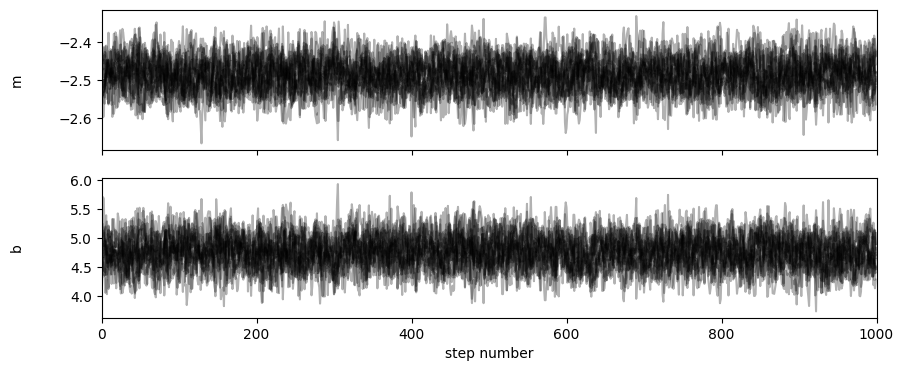

In [53]:
fig, axes = plt.subplots(ndim, figsize=(10, 4), sharex=True)
axes = np.atleast_1d(axes)
samples = sampler.get_chain(thin=5)
labels = ["m", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

In [54]:
flat_samples = sampler.get_chain(thin=5, flat=True)
flat_samples.shape

(16000, 2)

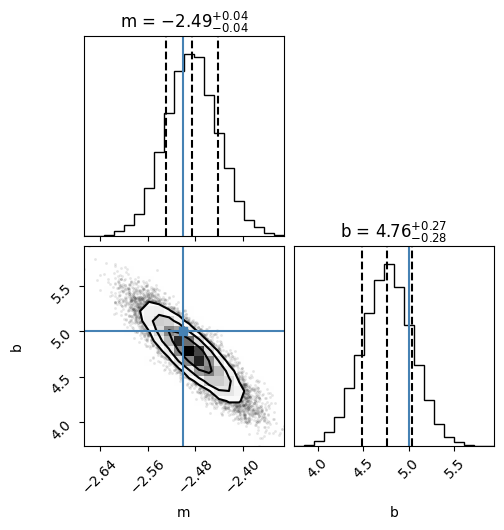

In [55]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
);

In [56]:
m_samples = flat_samples[:,0]
b_samples = flat_samples[:,1]

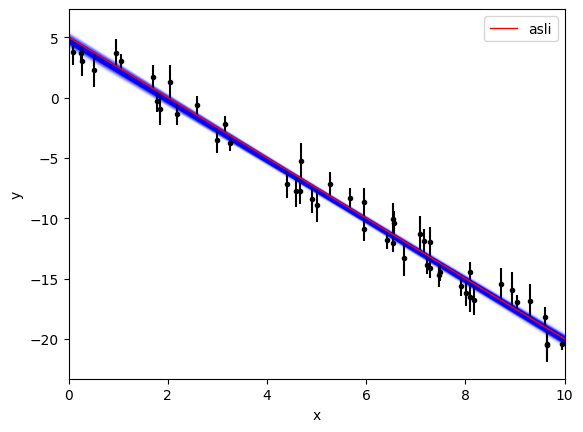

In [57]:
def sampled(theta, M):
    L, K = theta.shape
    indices = np.random.choice(L, size=M, replace=True)
    samples = theta[indices, :]
    return samples

theta_samples = sampled(flat_samples, 1000)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
for theta_i in theta_samples:
  m_i = theta_i[0]
  b_i = theta_i[1]
  plt.plot(x0, model(x0, m_i, b_i), "b", alpha=0.01, lw=1)
plt.plot(x0, m_true * x0 + b_true, "r", alpha=1, lw=1, label="asli")
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");
plt.legend()

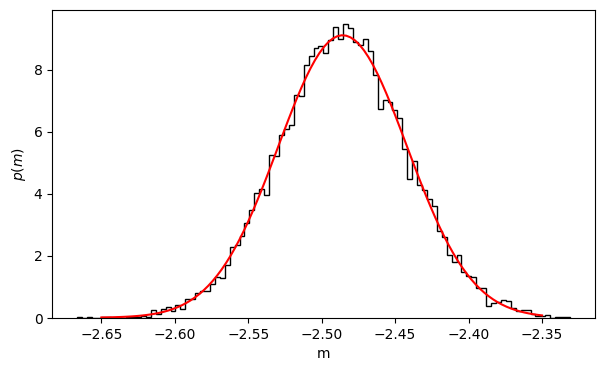

(-2.485749029890827, 0.043806327547872385)

In [59]:
m_fit = stats.norm.fit(m_samples)
ms = np.linspace(-2.65, -2.35, 100)
pm = stats.norm.pdf(ms, *m_fit)

plt.figure(figsize=(7,4))
plt.hist(m_samples, bins=100, density=True, color="k", histtype="step")
plt.plot(ms, pm, c="r")
plt.xlabel("m")
plt.ylabel(r"$p(m)$")
plt.show()

m_fit

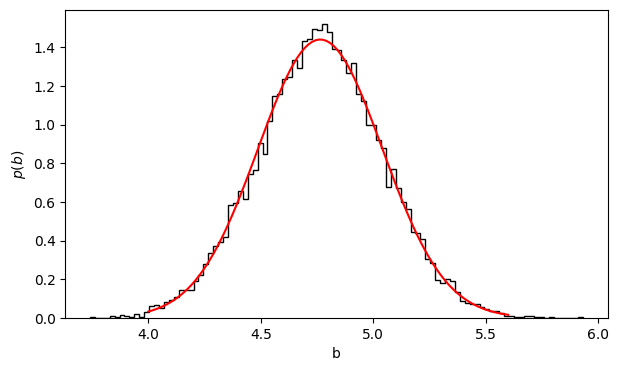

(4.7642342757929255, 0.2768081006464612)

In [61]:
b_fit = stats.norm.fit(b_samples)
bs = np.linspace(4, 5.6, 100)
pb = stats.norm.pdf(bs, *b_fit)

plt.figure(figsize=(7,4))
plt.hist(b_samples, bins=100, density=True, color="k", histtype="step")
plt.plot(bs, pb, c="r")
plt.xlabel("b")
plt.ylabel(r"$p(b)$")
plt.show()

b_fit

# Latihan

In [62]:
df_z = pd.read_csv("nz.csv")
df_z

,z_mid,nz,nz_error
0,-195.0,836,28.913665
1,-185.0,1008,31.749016
2,-175.0,1098,33.136083
3,-165.0,1252,35.383612
4,-155.0,1422,37.709415
5,-145.0,1679,40.975602
6,-135.0,1885,43.416587
7,-125.0,2171,46.593991
8,-115.0,2381,48.795492
9,-105.0,2585,50.842895


model:
\begin{align}
  n(z) = n_0\exp{\left(-\frac{z^2}{h_z^2}\right)}
\end{align}

parameter bebas: $\theta=\{n_0, h_z\}$

Prior:
\begin{align}
  p_0(n_0) \propto \begin{cases}
    1 & \text{jika } 4500 < x < 5500, \\
    0 & \text{lainnya.}
  \end{cases}
\end{align}

\begin{align}
  p_0(h_z) \propto \begin{cases}
    1 & \text{jika } 1 \text{ pc} < x < 200 \text{ pc}, \\
    0 & \text{lainnya.}
  \end{cases}
\end{align}

likelihood:
\begin{align}
\mathcal{L} \propto \prod_{i=1}^N \exp{\left[-\frac{\left(n(z_i)-n_{z,i}\right)^2}{2\sigma_{z,i}^2}\right]}
\end{align}

sehingga data: $D=\{z_i, n_{z,i}, \sigma_{z,i}\}$

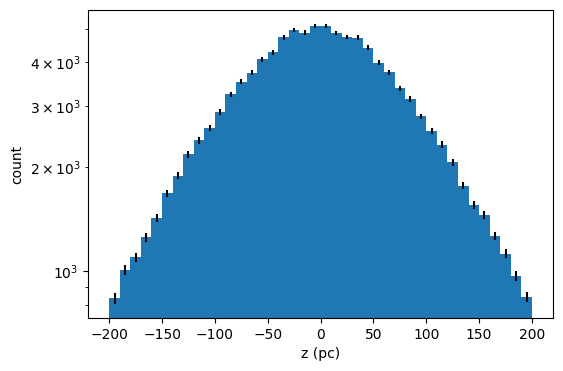

In [63]:
zi = df_z['z_mid'].values
nzi = df_z['nz'].values
sigma_zi = df_z['nz_error'].values

dz = zi[1] - zi[0]

plt.figure(figsize=(6,4))
plt.bar(zi, nzi, dz, yerr=sigma_zi, align="center")
plt.xlabel("z (pc)")
plt.ylabel("count")
plt.yscale("log")
plt.show()

Kerjakan di sini...

In [ ]:
data = ...

In [ ]:
def log_prior(theta):
  n0 = ...
  hz = ...

  log_prior_n0 = ...
  log_prior_hz = ...
  return ...

def model(...):
  return ...

def log_likelihood(theta, data):
  n0 = ...
  hz = ...

  zi = ...
  nzi = ...
  sigma_zi = ...

  nz_mod = ...

  log_res = ...
  return ...

def log_prob(theta, data):
  ...
  ...
  return ...

In [260]:
# cek
n0 = ... # pilih sembarang angka
hz = ... # pilih sembarang angka
theta = np.array([n0, hz])

print("prior", log_prior(theta))
print("likelihood", log_likelihood(theta, data))
print("posterior", log_prob(theta, data))
# apakah hasilnya sesuai harapan?
# jika tidak, inspeksi ulang definisi distribusi prior, likelihood, dan posterior

In [ ]:
ndim = ...
nwalkers = ...

n0_0 = ...
hz_0 = ...

p0 = ...
# cek bentuk p0, harusnya memiliki nwalkers baris dan ndim kolom
p0

In [ ]:
# cek, apakah untuk setiap nilai posisi awal pejalan
# nilai log_prob nya baik-baik saja (tidak ada yang -inf)
for p0_i in p0:
  print(log_prob(p0_i, data))

In [ ]:
# buat objek mcmc
nsteps = ... # pilih jumlah langkah awal

sampler = ...

state = ...

In [275]:
# buat trace plot
...
...

In [ ]:
# reset sampler jika nsteps yang dipilih sudah cukup besar
# sehingga trace plot nya sudah mencapai setimbang
sampler.reset()

In [ ]:
# jalankan lagi mcmc nya
sampler.run_mcmc(...);

In [ ]:
# buat trace plot lagi, cek apakah hasilnya sudah ok
...
...

In [ ]:
# flatten hasil mcmc
flat_samples = ...
# cek dimensinya, apakah ok
flat_samples.shape

In [ ]:
# buat corner plot

fig = corner.corner(...);

In [ ]:
# plot ulang nz vs z dengan error bar
# lalu tampilkan pula plot fit hasil mcmc

# fungsi pembantu untuk mensampel theta sebanya M kali,
# agar membuat plot sampel sedikit saja dari keseluruhan
# hasil mcmc
def sampled(theta, M):
    L, K = theta.shape
    indices = np.random.choice(L, size=M, replace=True)
    samples = theta[indices, :]
    return samples


theta_samples = sampled(...)
zs = np.linspace(-200, 200, 100)
plt.errorbar(...)
for theta_i in theta_samples:
  n0_i = theta_i[0]
  hz_i = theta_i[1]
  plt.plot(...)
plt.xlabel("z (pc)")
plt.ylabel("Count")
plt.yscale("log")
plt.show()

ekstrak hasil mcmc-nya

In [ ]:
n0_samples = ...
hz_samples = ...

In [ ]:
# buat plot histogram untuk hasil mcmc n0
# dan fit dengan distribusi normal
...
...

# berapa nilai $n_0$ besera ketidakpasiannya?

$n_0 = \dots \pm \dots$

In [ ]:
# buat plot histogram untuk hasil mcmc hz
# dan fit dengan distribusi normal
...
...

# berapa nilai $h_z$ besera ketidakpasiannya?

$h_z = \left(\dots \pm \dots\right) \text{ pc}$